## Part-1 : Panorama stitching

In [4]:
# pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=d1bcddbed265d90d4eaccbdc3e6aab86d26493a9102637576dd91c34b9557ac5
  Stored in directory: /home/mahendra/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)
%matplotlib inline

In [2]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

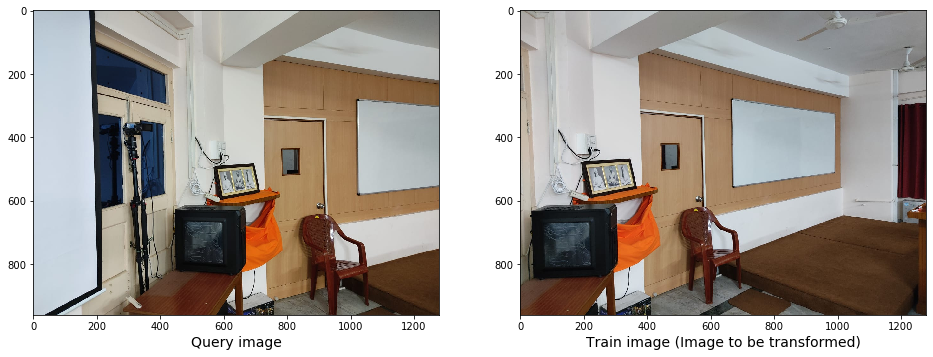

In [73]:
trainImg = imageio.imread("s1.jpeg")
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread("s2.jpeg")
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [74]:
descriptor = cv2.ORB_create()
kpsA, featuresA = descriptor.detectAndCompute(trainImg_gray, None)
kpsB, featuresB = descriptor.detectAndCompute(queryImg_gray, None)

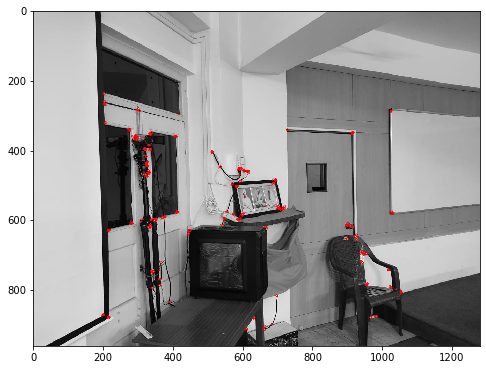

In [75]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(255,0,0)))

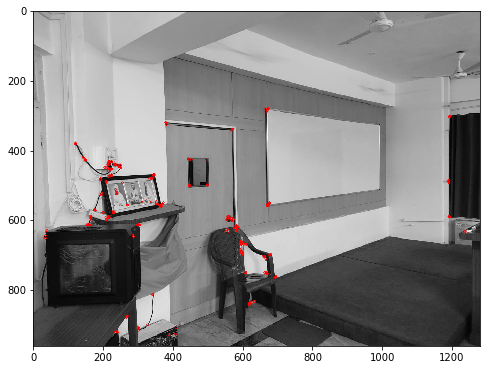

In [76]:
plt.figure(figsize=(8,8))
plt.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(255,0,0)))

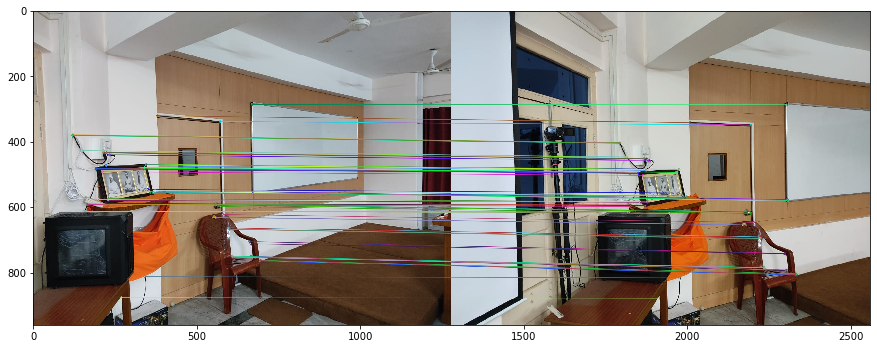

In [77]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
best_matches = bf.match(featuresA,featuresB)
rawMatches = sorted(best_matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,rawMatches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,15))
plt.imshow(img3)

In [78]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [79]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, rawMatches, reprojThresh=4)
(matches, H, status) = M
print(H)

[[ 5.46153993e-01 -2.24386823e-02  4.31439210e+02]
 [-1.55754208e-01  8.24237498e-01  9.08291352e+01]
 [-3.23244803e-04 -2.80053222e-05  1.00000000e+00]]


(-0.5, 2559.5, 1919.5, -0.5)

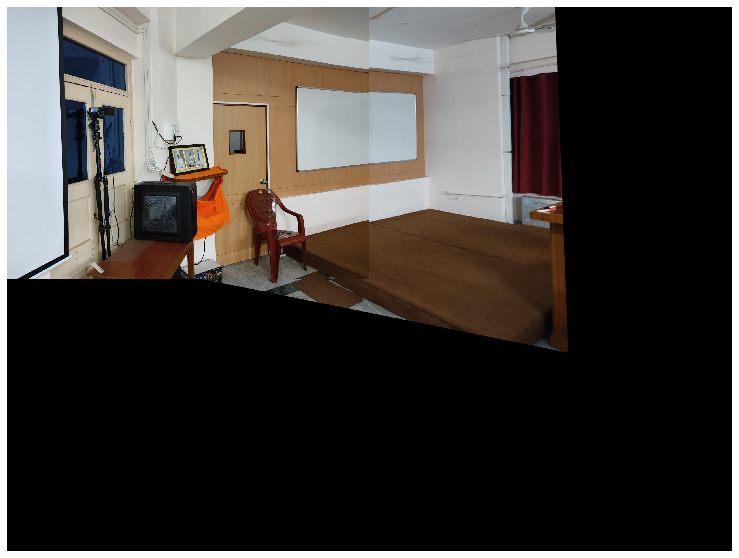

In [80]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)
plt.axis('off')


## Part-2 : Disparity Map

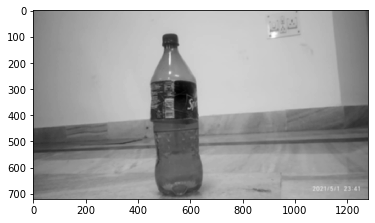

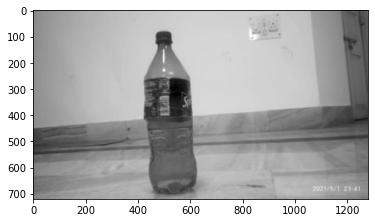

In [55]:
imgL = cv2.GaussianBlur(cv2.imread('p7.jpeg',0),(7,7),3)
imgR = cv2.GaussianBlur(cv2.imread('p8.jpeg',0),(7,7),3)

# imgL = cv2.resize(imgL, (800, 1280))
# imgR = cv2.resize(imgR, (800, 1280))

plt.imshow(imgL, cmap='gray')
plt.show()
plt.imshow(imgR, cmap='gray')
plt.show()

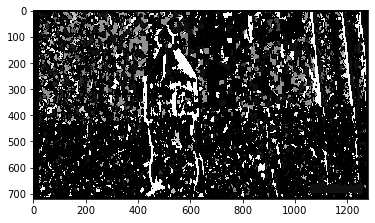

In [56]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
